In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale

In [2]:
#Get adult data 
data = pd.read_csv("./Data/Howell1.csv", sep = ';')
data = data[data['age'] > 18]
data['male'] = pd.Categorical(data['male'])

data['male']

0      1
1      0
2      0
3      1
4      0
      ..
534    0
537    0
540    1
541    0
543    1
Name: male, Length: 346, dtype: category
Categories (2, int64): [0, 1]

In [3]:
with pm.Model() as model:
    height_data = pm.ConstantData('height_data',scale(data['height']),dims = 'obs_id')
    weight_data = pm.ConstantData('weight_data',scale(data['weight']),dims = 'obs_id')
    b     = pm.Uniform('b',0,1)
    a     = pm.Normal('a',0,10)
    sigma = pm.Uniform('sigma',0,10)
    
    mu = pm.Deterministic('mu', a + b * height_data,dims = 'obs_id')
    
    likelihood_W = pm.Normal('likelihood_W',mu,sigma,observed=weight_data,dims='obs_id')
    
    sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

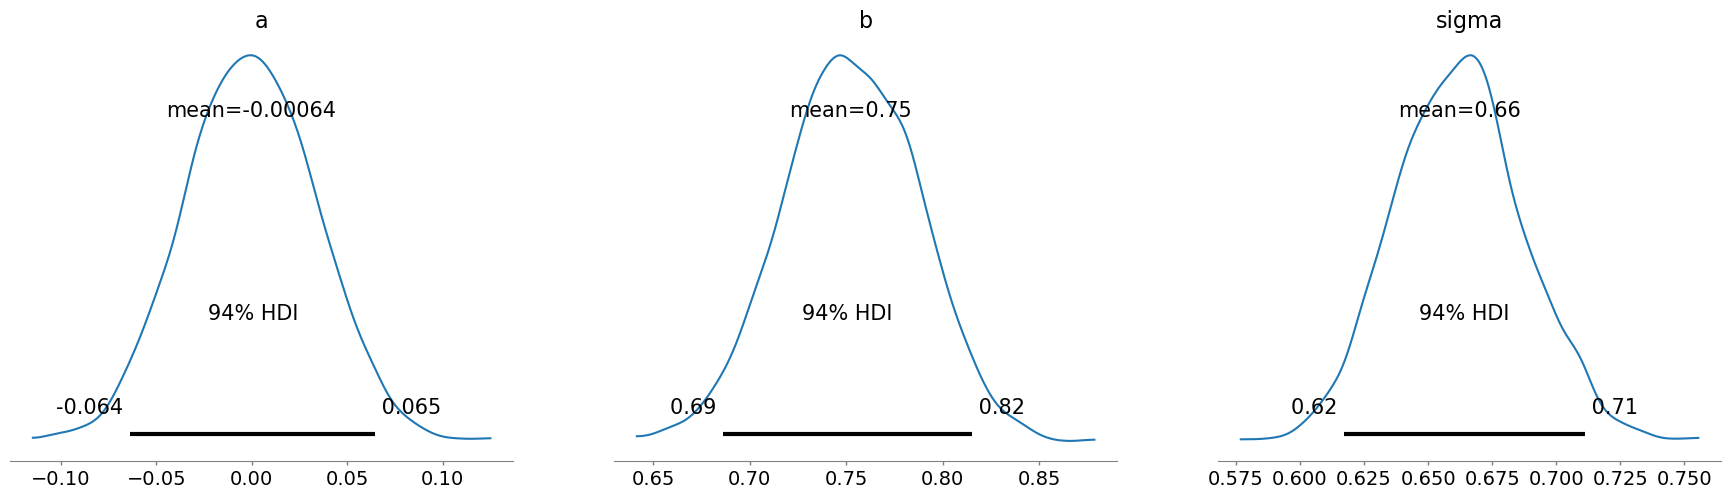

In [4]:
az.plot_posterior(sample, var_names=['a','b','sigma'])

In [5]:
#Simulating lines from prior
with model:
    sample.extend(pm.sample_prior_predictive(samples=100))

Sampling: [a, b, likelihood_W, sigma]


Text(0.5, 1.0, 'Prior predictive checks -- Flat priors')

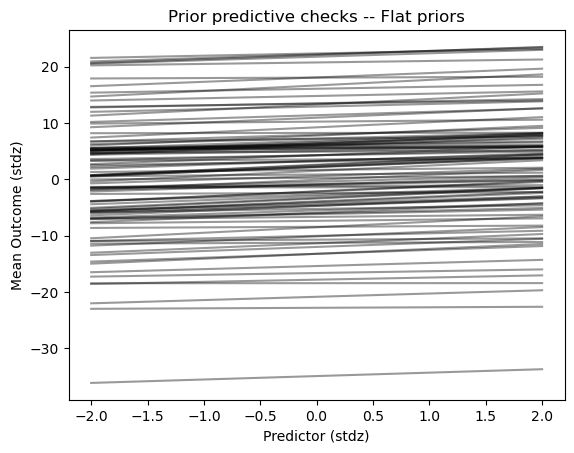

In [6]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
y = sample['prior']["a"] + sample['prior']["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors")

The prior prediction has reasonable slopes, but pretty unreasonable intercepts. 

In [7]:
#Simulation based Validation
#Simulation based calibration? 
sim_H = np.random.normal(0,5,1000)
U     = np.random.normal(0,5,len(sim_H))
b     = 0.2
sim_W = b*sim_H + U
sim_W[:10]

array([ 4.44538003, -4.13193522,  7.20200327,  0.6991386 , -4.98791256,
        3.99893584,  8.26654566, -1.69779426, -6.11352096, -5.49512228])

In [8]:
with pm.Model() as sim_model:
    height_data = pm.ConstantData('height_data',sim_H,dims = 'obs_id')
    weight_data = pm.ConstantData('weight_data',sim_W,dims = 'obs_id')
    b     = pm.Uniform('b',0,1)
    a     = pm.Normal('a',0,10)
    sigma = pm.Uniform('sigma',0,10)
    
    mu = pm.Deterministic('mu', a + b*height_data,dims = 'obs_id')
    
    likelihood_W = pm.Normal('likelihood_W',mu,sigma,observed=weight_data,dims='obs_id')
    
    sim_sample = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

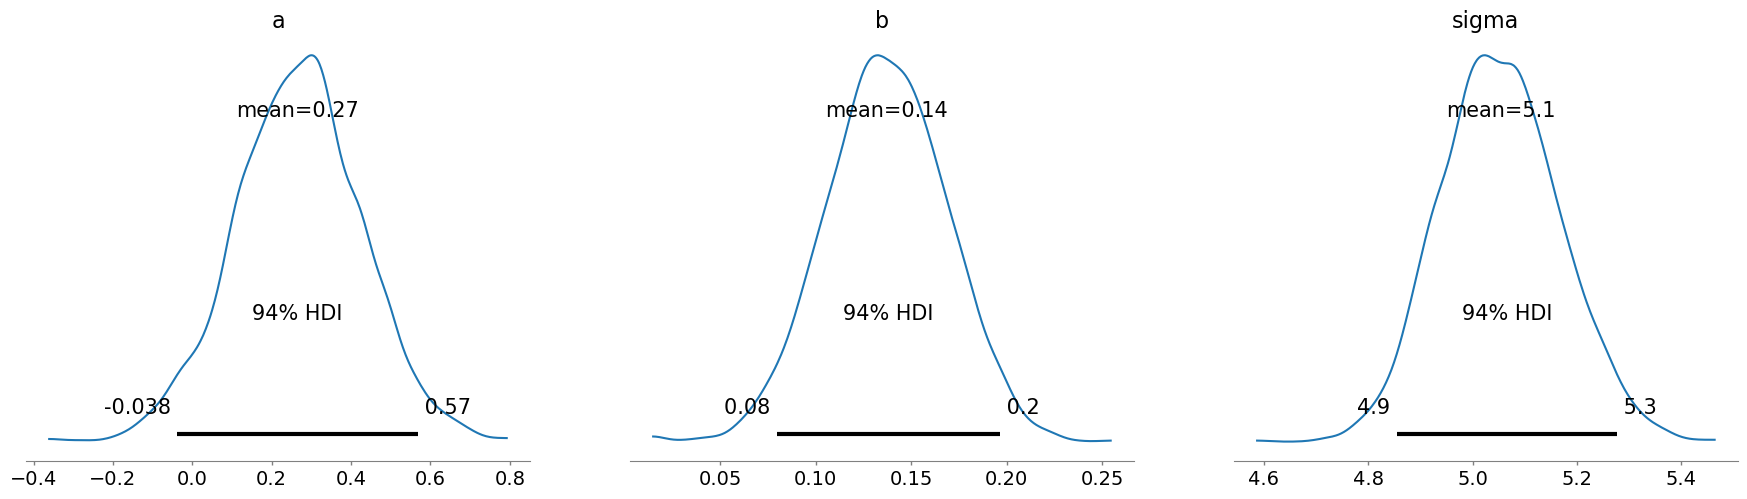

In [9]:
az.plot_posterior(sim_sample, var_names=['a','b','sigma'])

array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

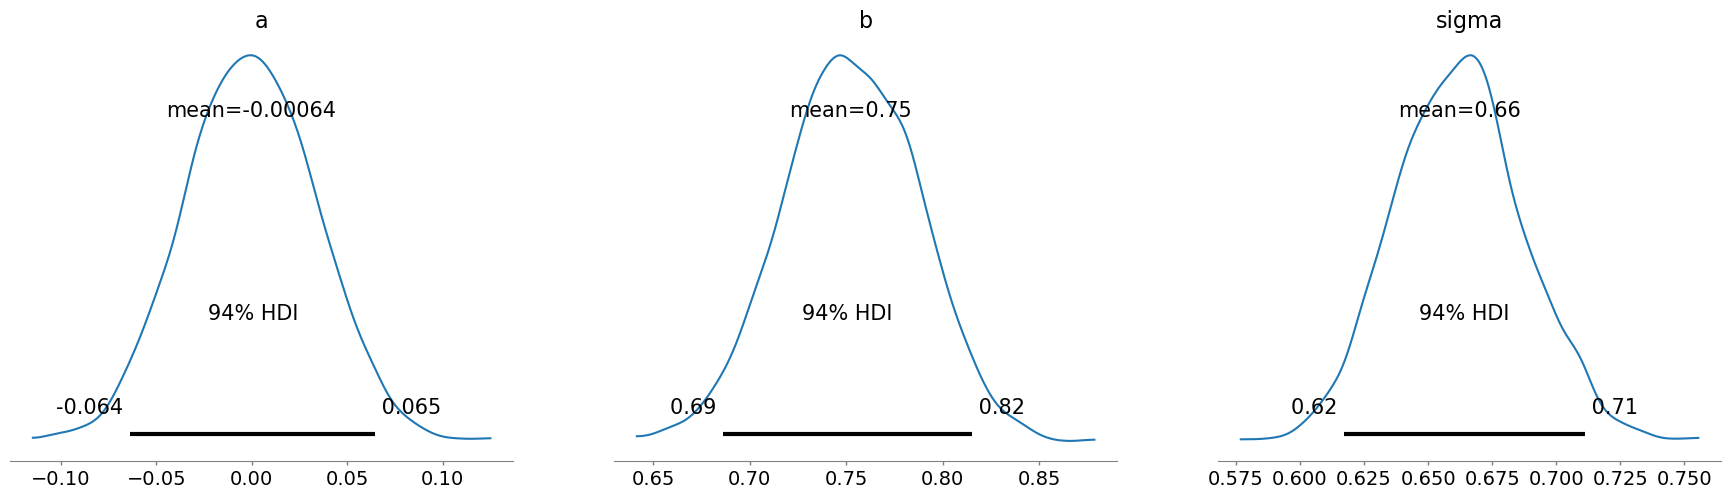

In [10]:
az.plot_posterior(sample, var_names=['a','b','sigma'])

In [11]:
with model:
    pm.sample_posterior_predictive(sample,extend_inferencedata = True)

Sampling: [likelihood_W]


In [12]:
sample['posterior_predictive']

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, obs_id: 346)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_id        (obs_id) int32 0 1 2 3 4 5 6 7 ... 339 340 341 342 343 344 345
Data variables:
    likelihood_W  (chain, draw, obs_id) float64 -0.4542 -1.898 ... -0.9864
Attributes:
    created_at:                 2023-08-23T07:11:32.338643
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.7.2

<AxesSubplot: xlabel='likelihood_W / likelihood_W'>

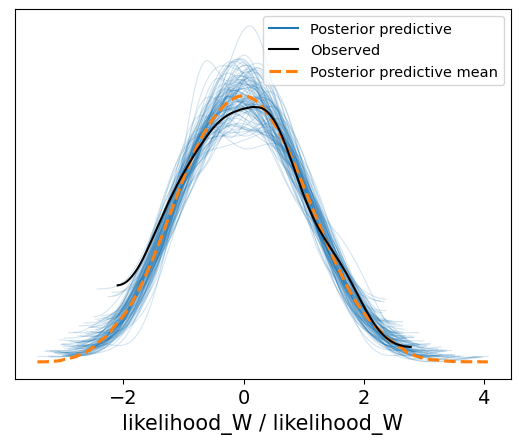

In [13]:
az.plot_ppc(sample, num_pp_samples=100)

In [14]:
#Direct method 
mu_pp = sample.posterior['a'] + sample.posterior['b']*xr.DataArray(scale(data['height']), dims =['obs_id'])

Text(0, 0.5, 'Outcome (H) (stdz)')

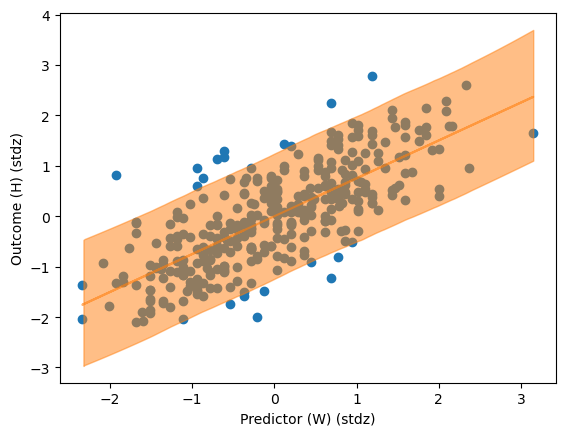

In [15]:
_, ax = plt.subplots()

ax.plot(
    scale(data['height']), mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(scale(data['height']), sample.observed_data["likelihood_W"])
az.plot_hdi(scale(data['height']), sample.posterior_predictive["likelihood_W"])

ax.set_xlabel("Predictor (W) (stdz)")
ax.set_ylabel("Outcome (H) (stdz)")

## Lecture 4 Content

Generative model + multiple estimands = multiple estimators

Processing results, only very simple causal estimates show up
summary tables

Categories & Curves

    - Linear models can do extra-linear things
    - Categories (indicator & index variables)
    - Splines and other additive structures 
Categories:

    - Causes that are not continuous
    Categories: Discrete, unordered types
    - Want to **stratify** by category: fit sepearate line for each
    
Using the Howell example: How are height/weight/sex causally
related?

$H = f(S,U)$  U is unobserved

$W = F(H,S,V)$  V is unobserved

The unobserved causes are ignorable unless they are shared!

In [16]:
#Generative model
N = 50 #N women and N men
H_W = 150 + np.random.normal(0,5,N)
H_M = 160 + np.random.normal(0,5,N)
W_W = 0 + 0.5*H_W + np.random.normal(0,5,N)
W_M = 0 + 0.6*H_M + np.random.normal(0,5,N)
women_d = {'S':np.zeros(N).astype(int),
          'H': H_W,
          'W':W_W}
men_d = {'S':np.ones(N).astype(int),
        'H': H_M,
        'W': W_M}

sexsim_d = pd.concat([pd.DataFrame(x) for x in [women_d,men_d]], ignore_index=True)

#Women = 0, Men = 1 
sexsim_d

,S,H,W
0,0,150.117691,73.664410
1,0,153.667904,76.913518
2,0,141.839131,76.279136
3,0,143.431123,65.527764
4,0,153.755757,71.128735
...,...,...,...
95,1,170.864416,96.692742
96,1,161.818333,102.921646
97,1,166.852373,102.816407
98,1,166.439498,97.823528


Different causal questions need different statistical models

Q: Causal effect of H on W?

Q: Causal effect of S on W?

Q: Direct causal effect of S on W?

In [17]:
#Effect of sex in sim
np.mean(men_d['W'] - women_d['W'])

22.7048322446178

In [18]:
sexsim_d['S'] = pd.Categorical(sexsim_d['S'])
sexsim_d['S'].cat.categories.size

2

## Model Simulation 
Going to use index variables for sex

In [19]:
with pm.Model() as sex_sim:
    #Priors
    sigma = pm.Uniform('sigma',0,10)
    a = pm.Normal('a',60,10,shape = sexsim_d['S'].cat.categories.size)
    
    mu = a[sexsim_d['S']]# + b[sexsim_d['S']]*sexsim_d['H'] + u
    
    W = pm.Normal('W',mu,sigma, observed = sexsim_d['W'])
    sex_sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


array([<AxesSubplot: title={'center': 'a\n0'}>,
       <AxesSubplot: title={'center': 'a\n1'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

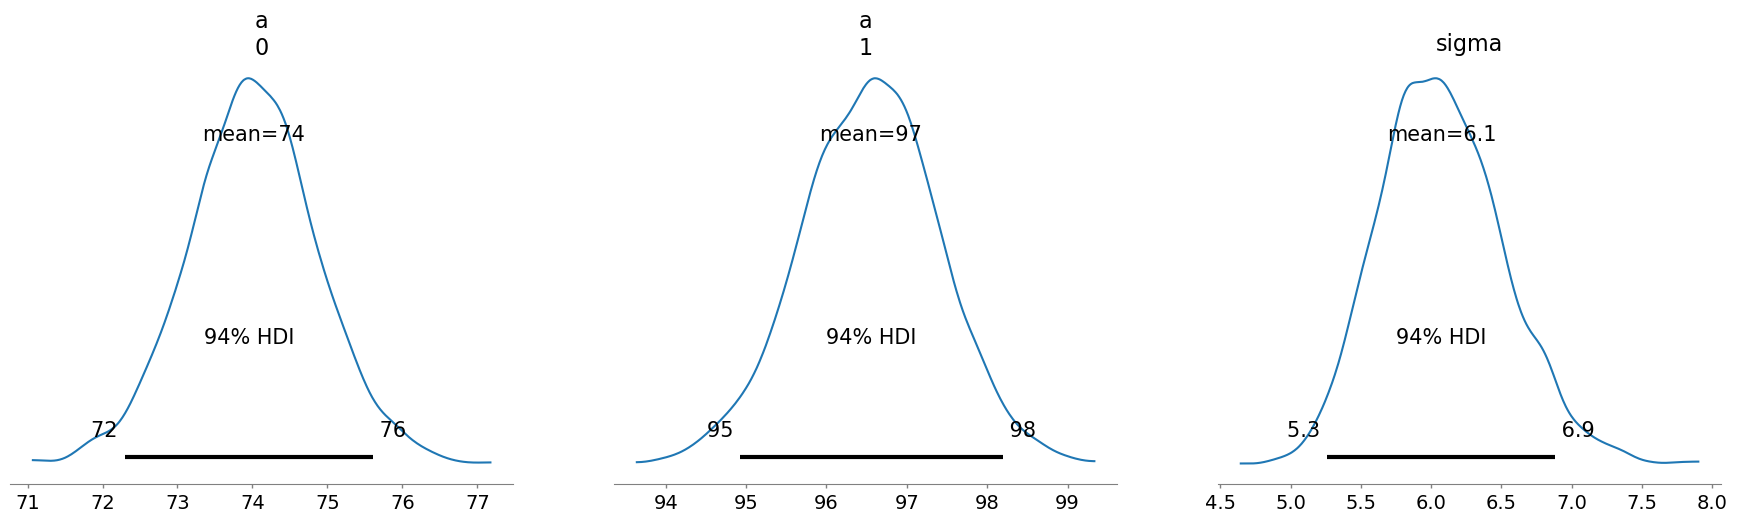

In [20]:
az.plot_posterior(sex_sim_trace)

In [21]:
(sex_sim_trace['posterior']['a'][:,:,0] - sex_sim_trace['posterior']['a'][:,:,1])

<xarray.DataArray 'a' (chain: 4, draw: 1000)>
array([[-21.58037196, -23.95221432, -21.20925471, ..., -22.47523216,
        -22.47523216, -22.58943759],
       [-23.52908255, -21.12237168, -24.98666071, ..., -21.62526499,
        -25.08876597, -23.91714077],
       [-23.42133624, -20.79599422, -22.89155394, ..., -23.38265111,
        -23.14242029, -23.31123701],
       [-22.46367041, -22.46367041, -23.01250431, ..., -23.24411719,
        -23.97088357, -22.06105953]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

<AxesSubplot: title={'center': 'a'}>

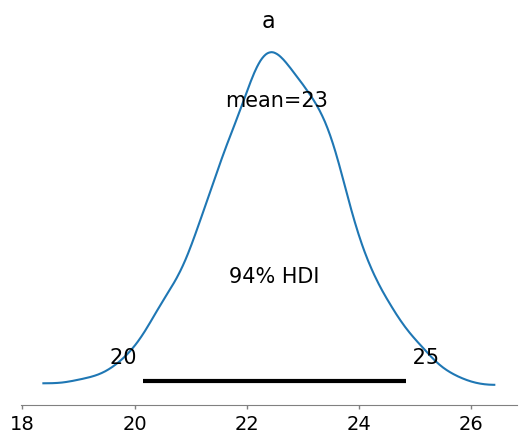

In [22]:
#Computing the contrast by takign the difference between the two variables. This is the estimand
#This is the posterior distribution of differences
#OUr knowledge of average difference. 
az.plot_posterior((sex_sim_trace['posterior']['a'][:,:,1] - sex_sim_trace['posterior']['a'][:,:,0]))

In [23]:
with sex_sim:
    sex_sim_trace.extend(pm.sample_posterior_predictive(sex_sim_trace))

Sampling: [W]


array([<AxesSubplot: title={'center': 'a\n0'}>,
       <AxesSubplot: title={'center': 'a\n1'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

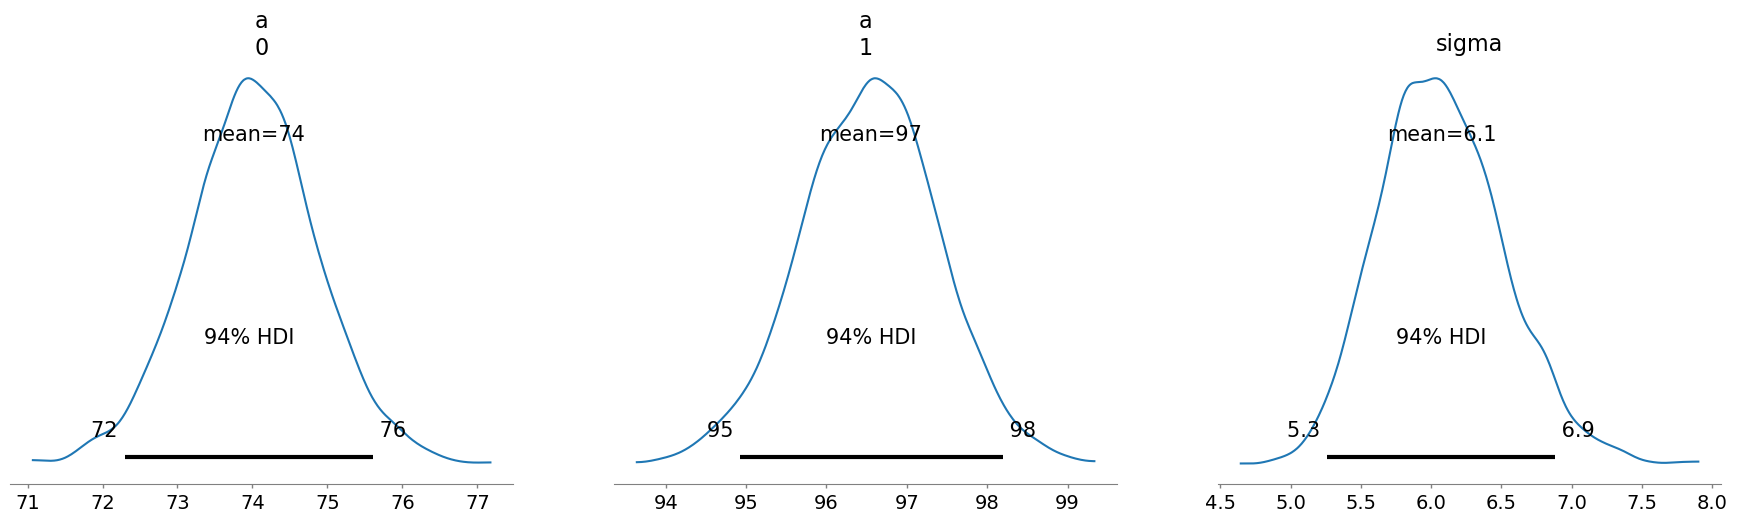

In [24]:
az.plot_posterior(sex_sim_trace)

<AxesSubplot: xlabel='W / W'>

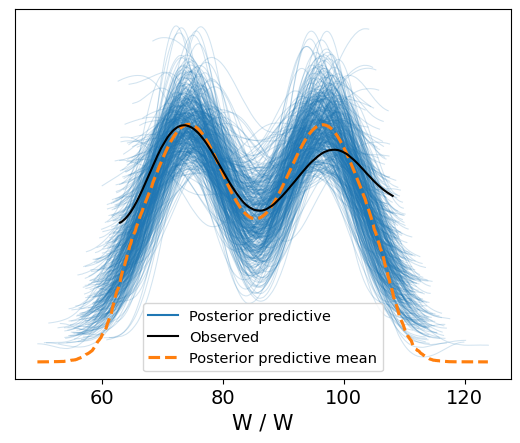

In [25]:
#np.random.normal(sex_sim_trace['posterior']['a'][:,:,1],sex_sim_trace['posterior']['sigma'],1)
az.plot_ppc(sex_sim_trace,num_pp_samples=400)

In [26]:
sex_sim_trace['posterior_predictive']['W'].shape

(4, 1000, 100)

In [27]:
sex_sim_mean = az.summary(sex_sim_trace)['mean']
sex_sim_mean

a[0]     74.012
a[1]     96.543
sigma     6.075
Name: mean, dtype: float64

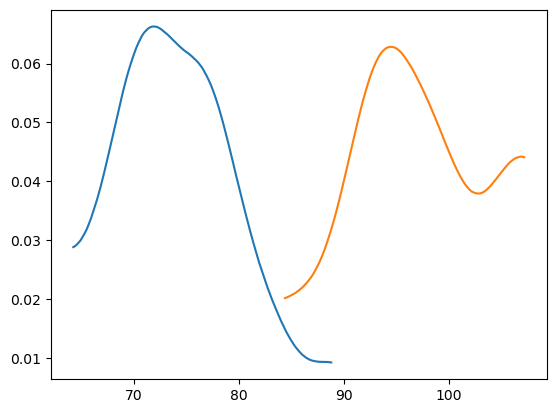

In [28]:
w_test = np.random.normal(sex_sim_mean['a[0]'],sex_sim_mean['sigma'],50)
m_test = np.random.normal(sex_sim_mean['a[1]'],sex_sim_mean['sigma'],50)
gridw, pdfw = az.kde(w_test)
gridm, pdfm = az.kde(m_test)
plt.plot(gridw, pdfw)
plt.plot(gridm, pdfm)


<AxesSubplot: >

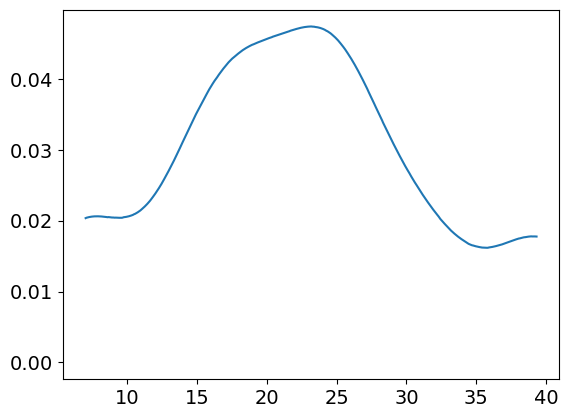

In [29]:
#plotting test contrast
contrast_test = m_test - w_test
az.plot_kde(contrast_test)

## Actual Data 

In [30]:
## Using actual data
with pm.Model() as sex_model:
    sigma = pm.Uniform('sigma',0,10)
    a = pm.Normal('a',60,10,shape = data['male'].cat.categories.size)
    #b = pm.Normal('b',0,1,shape = sexsim_d['S'].cat.categories.size)
    #u = pm.Normal('u',0,5)
#    mu = a[np.array(sexsim_d['S']).astype(int)]
    mu = a[data['male']]# + b[sexsim_d['S']]*sexsim_d['H'] + u
    
    W = pm.Normal('W',mu,sigma, observed = data['weight'])
    sex_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


array([<AxesSubplot: title={'center': 'a\n0'}>,
       <AxesSubplot: title={'center': 'a\n1'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

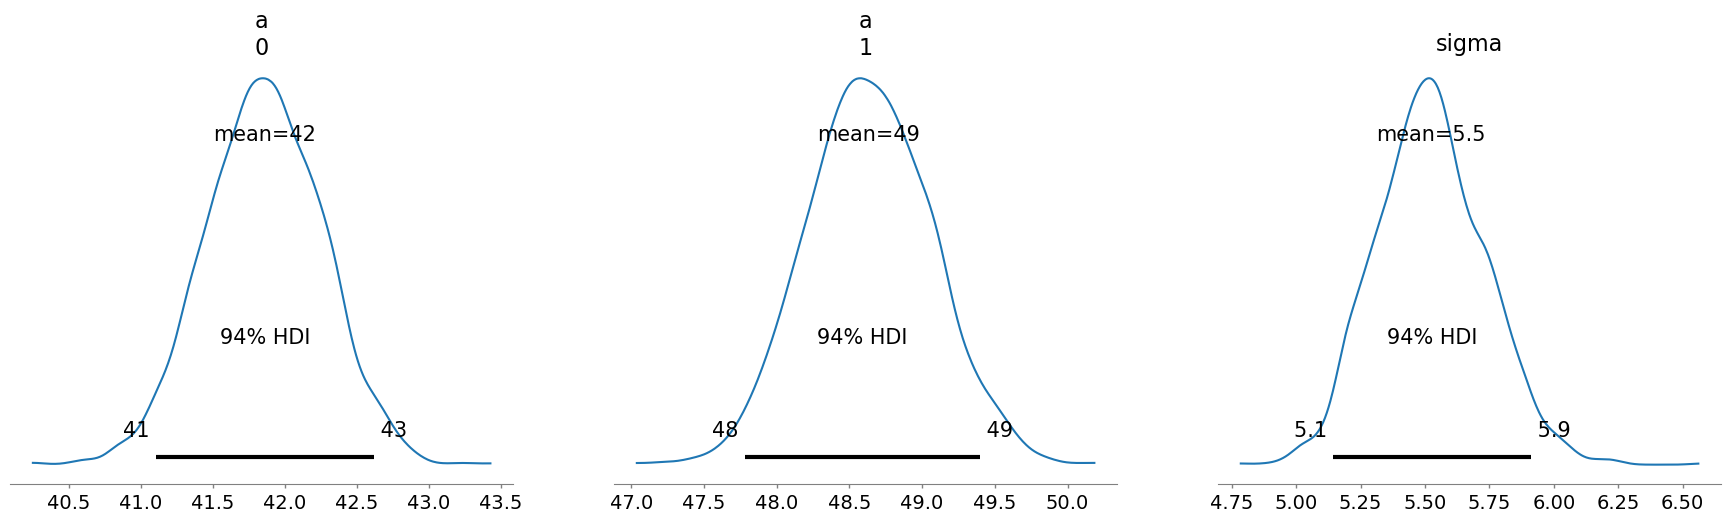

In [31]:
az.plot_posterior(sex_trace)

In [32]:
sex_mean = az.summary(sex_trace)['mean']
sex_mean

a[0]     41.857
a[1]     48.635
sigma     5.521
Name: mean, dtype: float64

## Our Answer/Estimand
The following graphs provide answers to our estimand, the causal effect of S on W. The two contrasts give answer as to their mean and the whole weight distributions. 

Causal effect because it lets you address the question of 'what happens to a persons weight, if we were to change their sex' it is a **distribution** and that is the estimate (points are not estimates, they are decisions).  

<AxesSubplot: title={'center': 'a'}>

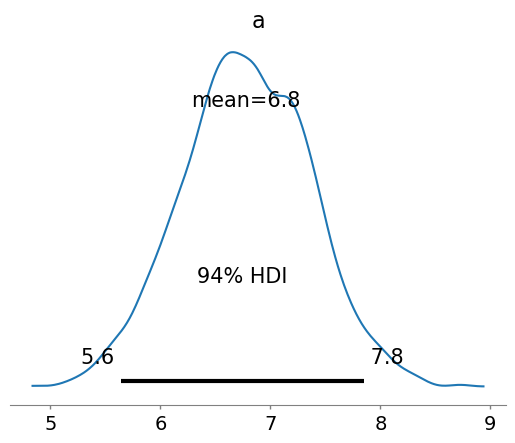

In [33]:
az.plot_posterior((sex_trace['posterior']['a'][:,:,1] - sex_trace['posterior']['a'][:,:,0]))

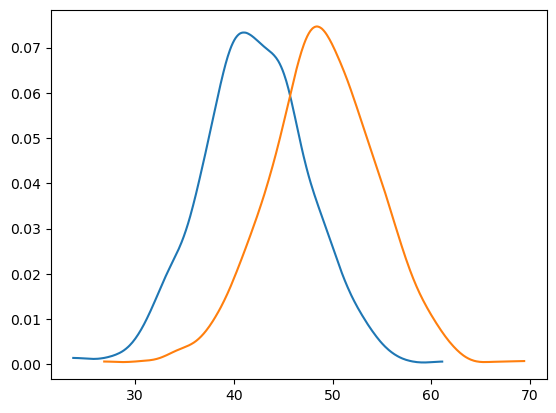

In [34]:
w = np.random.normal(sex_mean['a[0]'],sex_mean['sigma'],1000)
m = np.random.normal(sex_mean['a[1]'],sex_mean['sigma'],1000)
gridw, pdfw = az.kde(w)
gridm, pdfm = az.kde(m)
plt.plot(gridw, pdfw)
plt.plot(gridm, pdfm)

Text(0.5, 1.0, 'Posterior weight contrast Between M & W ')

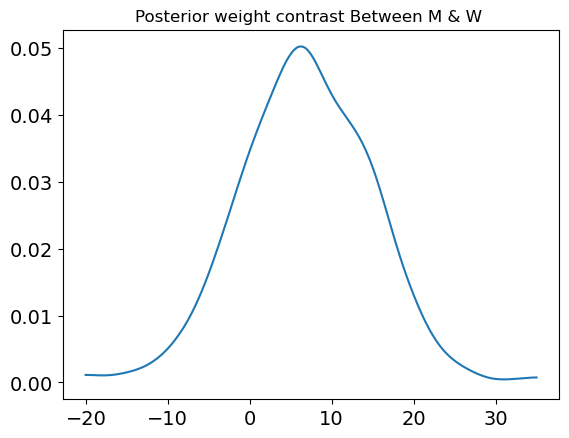

In [35]:
az.plot_kde(m-w) 
plt.title('Posterior mean weight contrast Between M & W ')

In [36]:
contrast = m-w
len(contrast[contrast >= 0])/1000

0.806

## Direct Causal Effect of S on W

Need to stratify by Height 

Need to center height by removing Hbar (average height). Makes alpha the average weight of a person with average height. Makes it easier to define priors for alpha

**Cool Fact**
A linear regression line will always pass through the average point (xbar,ybar)

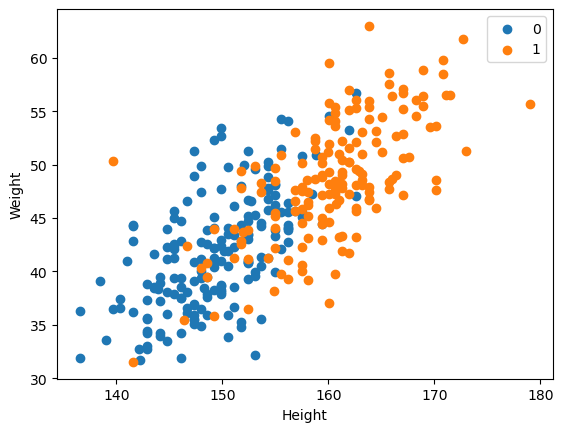

In [37]:
grouped = data.groupby('male')
for name,group in grouped:
    plt.scatter(group['height'],group['weight'],label=name)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

In [38]:
with pm.Model() as dsex_model:
    sigma = pm.Exponential('sigma',1)
    a     = pm.Normal('a',45,10, shape = data['male'].cat.categories.size)
    b     = pm.Normal('b', 0, 5, shape = data['male'].cat.categories.size)
    
    mu    = a[data['male']] + b[data['male']]*(data['height']-data['height'].mean()) #Need to center (hbar), a becomes expected weight when h is expected (average)
    W     = pm.Normal('W',mu,sigma,observed = data['weight'])
    dsex_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [39]:
az.summary(dsex_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.164,0.448,44.352,46.037,0.008,0.005,3417.0,2973.0,1.0
a[1],45.102,0.466,44.254,45.982,0.008,0.006,3283.0,2518.0,1.0
b[0],0.644,0.062,0.527,0.759,0.001,0.001,3279.0,3073.0,1.0
b[1],0.612,0.055,0.509,0.712,0.001,0.001,3322.0,3049.0,1.0
sigma,4.259,0.159,3.980,4.571,0.003,0.002,3405.0,2798.0,1.0


array([[<AxesSubplot: title={'center': 'a\n0'}>,
        <AxesSubplot: title={'center': 'a\n1'}>,
        <AxesSubplot: title={'center': 'b\n0'}>],
       [<AxesSubplot: title={'center': 'b\n1'}>,
        <AxesSubplot: title={'center': 'sigma'}>, <AxesSubplot: >]],
      dtype=object)

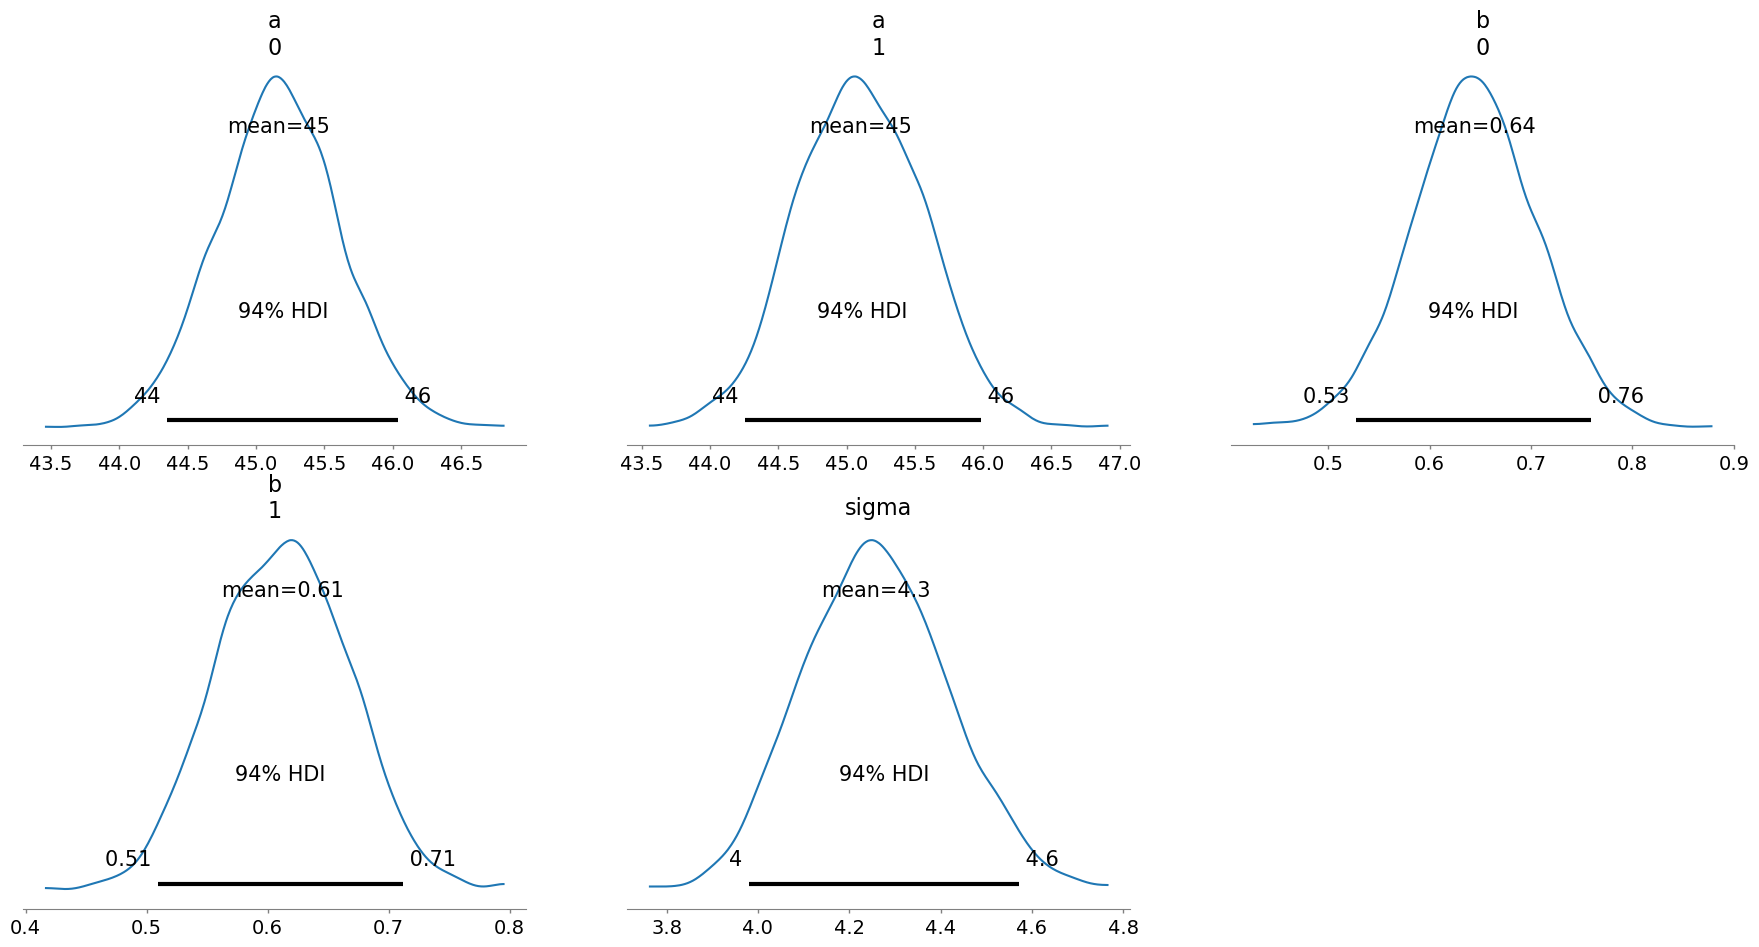

In [40]:
az.plot_posterior(dsex_trace)

In [41]:
x = np.linspace(data['height'].min(),data['height'].max(),100)
y0 = 45.153 + 0.644 * (x-np.mean(x))
y1 = 45.107 + 0.614 * (x-np.mean(x))

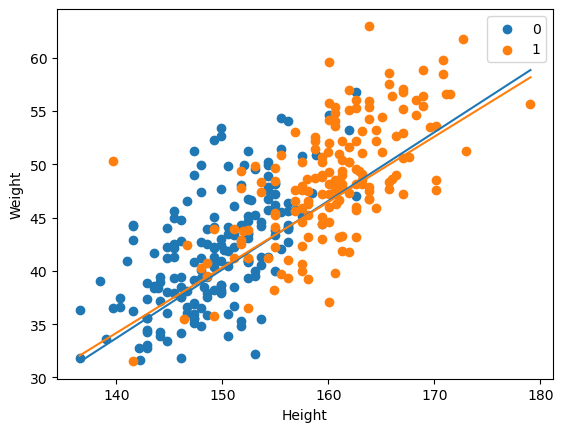

In [42]:
grouped = data.groupby('male')
for name,group in grouped:
    plt.scatter(group['height'],group['weight'],label=name)
plt.plot(x,y0)
plt.plot(x,y1)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

In [43]:
with dsex_model:
    dsex_trace.extend(pm.sample_posterior_predictive(dsex_trace, extend_inferencedata = True))
#az.plot_hdi(data['height'],dsex_trace.posterior['b'])

Sampling: [W]


<AxesSubplot: >

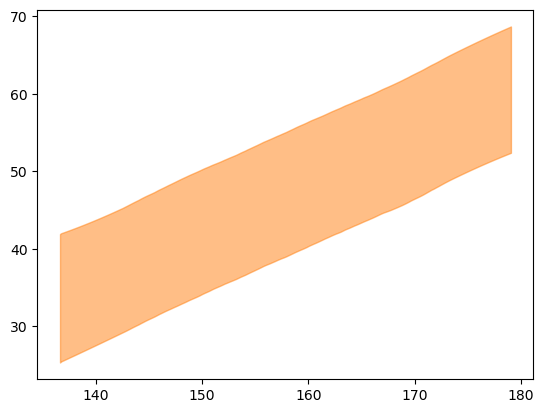

In [44]:
#az.plot_hdi(data['height'],dsex_trace.posterior_predictive)
az.plot_hdi(data['height'],dsex_trace.posterior_predictive['W'])

array([[<AxesSubplot: title={'center': 'a\n0'}>,
        <AxesSubplot: title={'center': 'a\n1'}>,
        <AxesSubplot: title={'center': 'b\n0'}>],
       [<AxesSubplot: title={'center': 'b\n1'}>,
        <AxesSubplot: title={'center': 'sigma'}>, <AxesSubplot: >]],
      dtype=object)

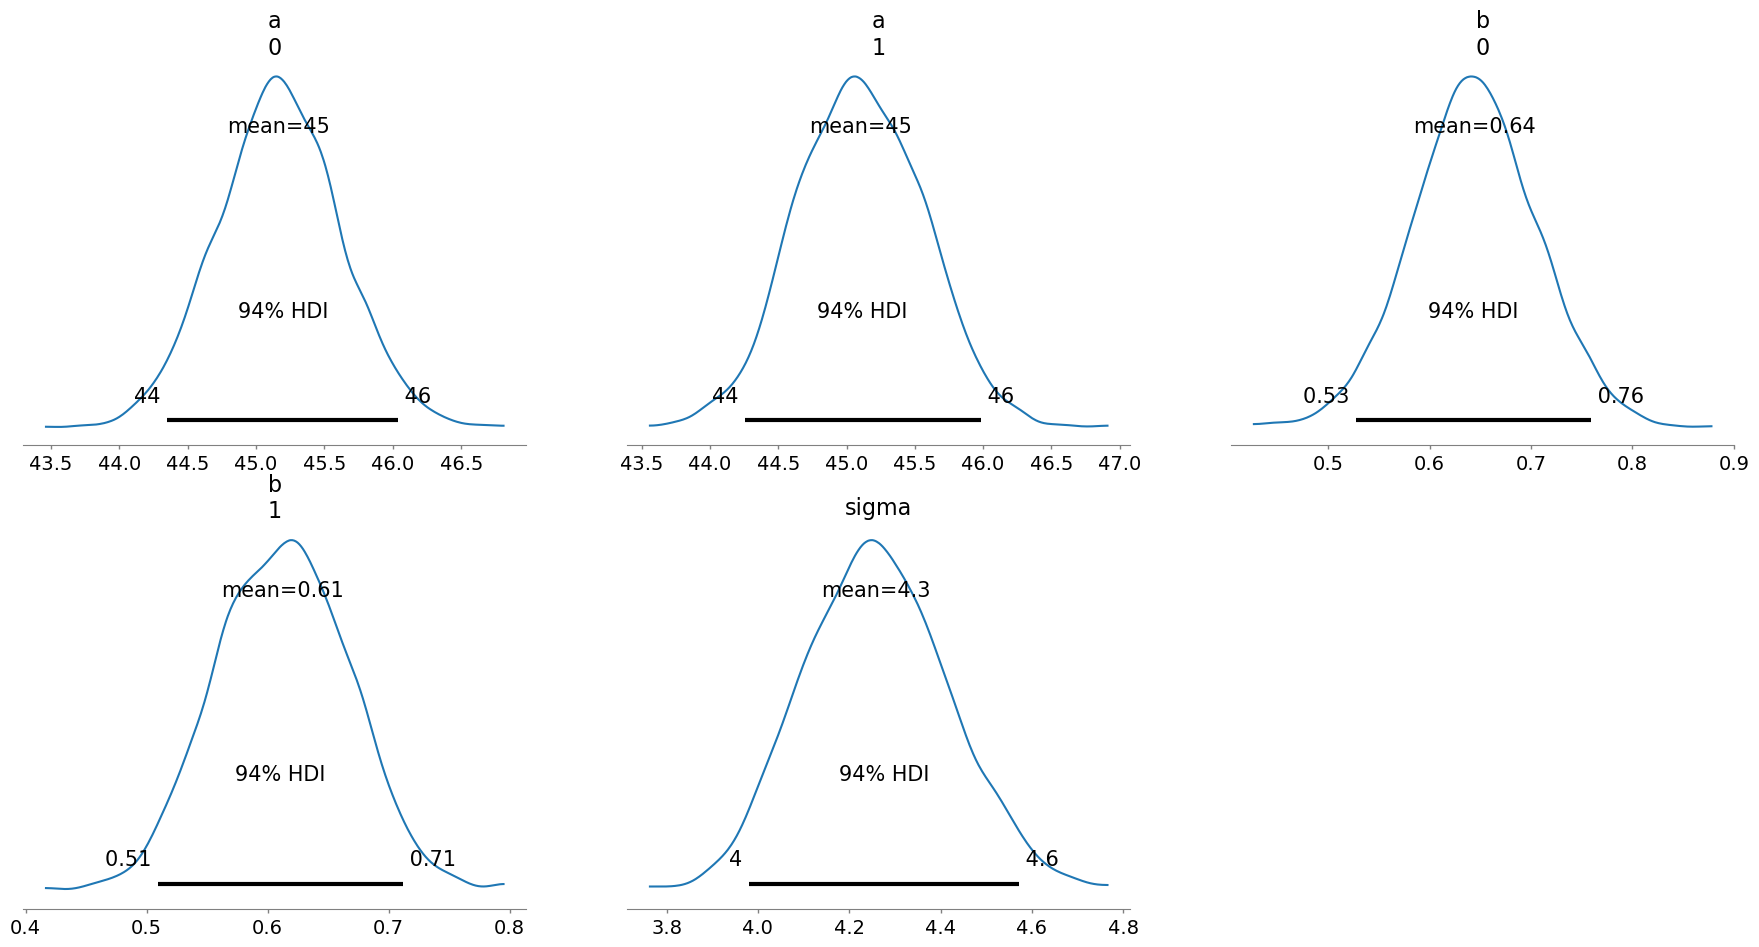

In [45]:
az.plot_posterior(dsex_trace)

In [46]:
az.summary(dsex_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.164,0.448,44.352,46.037,0.008,0.005,3417.0,2973.0,1.0
a[1],45.102,0.466,44.254,45.982,0.008,0.006,3283.0,2518.0,1.0
b[0],0.644,0.062,0.527,0.759,0.001,0.001,3279.0,3073.0,1.0
b[1],0.612,0.055,0.509,0.712,0.001,0.001,3322.0,3049.0,1.0
sigma,4.259,0.159,3.980,4.571,0.003,0.002,3405.0,2798.0,1.0


In [47]:
dsex_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [48]:
with dsex_model:
    dsex_pp = pm.sample_posterior_predictive(dsex_trace, var_names = ['a', 'b','W'])

Sampling: [W, a, b]


In [49]:
dsex_pp.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, a_dim_2: 2, b_dim_2: 2, W_dim_2: 346)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * a_dim_2  (a_dim_2) int32 0 1
  * b_dim_2  (b_dim_2) int32 0 1
  * W_dim_2  (W_dim_2) int32 0 1 2 3 4 5 6 7 ... 338 339 340 341 342 343 344 345
Data variables:
    a        (chain, draw, a_dim_2) float64 50.89 37.34 38.5 ... 46.79 57.08
    b        (chain, draw, b_dim_2) float64 -1.218 6.821 5.658 ... 5.811 -1.98
    W        (chain, draw, W_dim_2) float64 16.68 73.47 66.71 ... 56.67 47.19
Attributes:
    created_at:                 2023-08-23T07:12:31.297293
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.7.2

In [50]:
contrast_pp_a = dsex_pp.posterior_predictive['a'][1] - dsex_pp.posterior_predictive['a'][0]
contrast_pp_b = dsex_pp.posterior_predictive['b'][1] - dsex_pp.posterior_predictive['b'][0]
contrast_pp_w = dsex_pp.posterior_predictive['W'][1] - dsex_pp.posterior_predictive['W'][0]

In [51]:
#az.plot_density(contrast_pp_w)

array([[<AxesSubplot: title={'center': 'a\n0'}>,
        <AxesSubplot: title={'center': 'a\n1'}>,
        <AxesSubplot: title={'center': 'b\n0'}>],
       [<AxesSubplot: title={'center': 'b\n1'}>,
        <AxesSubplot: title={'center': 'sigma'}>, <AxesSubplot: >]],
      dtype=object)

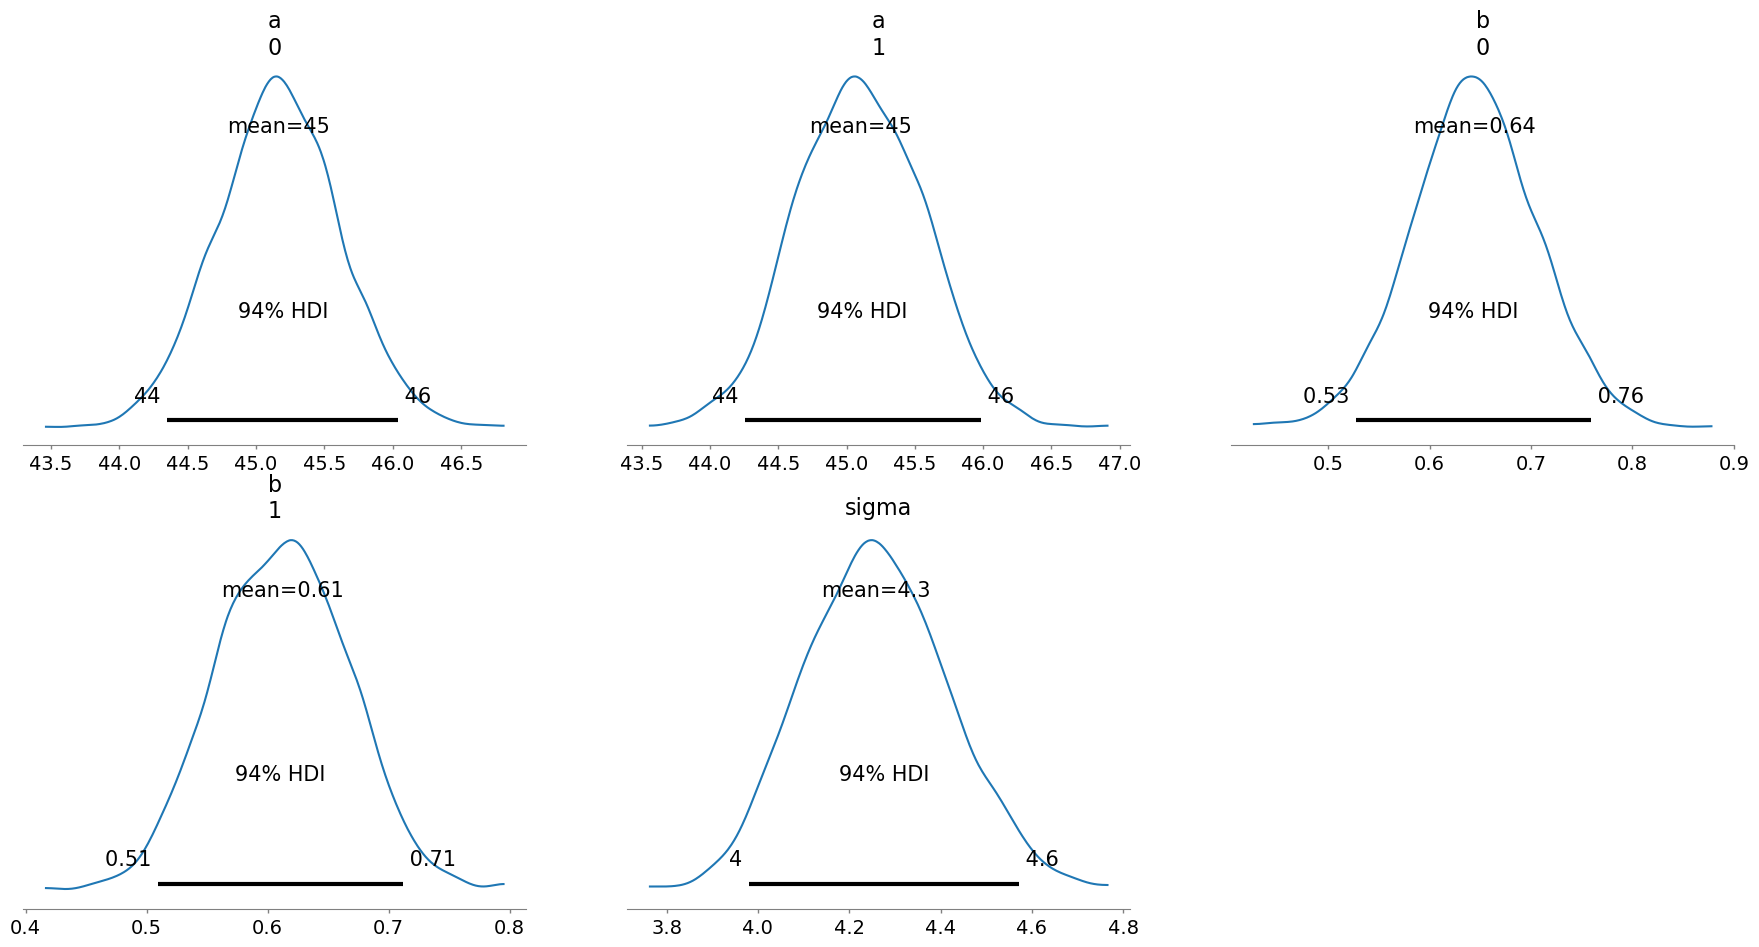

In [52]:
az.plot_posterior(dsex_trace)

In [53]:
#az.kde(dsex_pp.posterior_predictive['W'][0])=

## Full Luxury Bayes

Using one model, with all fo the submodels inside it. 


In [55]:
with pm.Model() as full_model:
    #Height
    tau = pm.Uniform('tau',0,10)
    h = pm.Normal('h',160,10,shape=2)
    nu = h[S]
    H = pm.Normal('H',nu,tau)

NameError: name 'S' is not defined